# Import and drive

Import statements

In [1]:
import zipfile
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import models
import torch.nn as nn
import csv

Mount the drive and enter the desired folder

In [2]:
# mount the drive
from google.colab import drive
drive.mount("/content/drive/")

# enter the desired folder
%cd drive/MyDrive/Colab_environments/WoodClassification/

Mounted at /content/drive/
/content/drive/MyDrive/Colab_environments/WoodClassification


Set the device

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Utility functions

In [4]:
# Loads a .tiff image using PIL.
# image_path: path to the image to be loaded.
# Returns an image with mode "L".
def load_image(image_path):

    # load the image with PIL
    image = Image.open(image_path)

    # convert it into a numpy array
    image_np = np.array(image)

    # max pixel value
    max_val = np.max(image_np)

    # new desired max value
    new_max_val = 255

    # normalize the pixels and convert their values into unsigned integers
    normalized_image = (image_np / max_val * new_max_val).astype(np.uint8)

    # return the greyscale image represented by the numpy array
    return Image.fromarray(normalized_image, mode="L")

In [5]:
# Function to compute the mean pixel value of images in folder_path.
# folder_path: path to the folder containing images.
# device: device to be used for the computation.
# Returns the mean value of pixels of images in folder_path.
def compute_mean(folder_path, device):

    # initialize the mean and the number of images
    mean = torch.tensor(0.0, device=device)
    n_images = torch.tensor(0, device=device)

    # iterate over each class folder
    for sub_dir_name in os.listdir(folder_path):

        # current sub directory
        curr_sub_dir = os.path.join(folder_path, sub_dir_name)

        # add to samples each tuple for the current class
        for file_name in os.listdir(curr_sub_dir):

            if file_name.endswith(".tiff"):

                # load the current image
                image = load_image(os.path.join(curr_sub_dir, file_name))

                # apply some other requested transformations
                transformations = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
                image = transformations(image).to(device)

                # update the mean and the number of images
                mean += image.mean()
                n_images += 1

    # return the mean over all images in the dataset
    return mean / n_images

In [6]:
# Function to compute the standard deviation of pixels of images in folder_path.
# folder_path: path to the folder containing images.
# device: device to be used for the computation.
# Returns the standard deviation of pixels of images in folder_path.
def compute_std(folder_path, mean, device):

    # initialize the variance and the number of images
    var = torch.tensor(0.0, device=device)
    n_images = torch.tensor(0, device=device)

    # iterate over each class folder
    for sub_dir_name in os.listdir(folder_path):

        # current sub directory
        curr_sub_dir = os.path.join(folder_path, sub_dir_name)

        # add to samples each tuple for the current class
        for file_name in os.listdir(curr_sub_dir):

            if file_name.endswith(".tiff"):

                # load the current image
                image = load_image(os.path.join(curr_sub_dir, file_name))

                # apply some other requested transformations
                transformations = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
                image = transformations(image).to(device)

                # update variance and counter
                var += ((image - mean) ** 2).mean()
                n_images += 1

    # return the std over all images in the dataset
    return torch.sqrt(var / n_images)

# Load model and weights

In [7]:
# number of classes for our classification task
n_classes = 7

# create an instance of the resnet50 model modified
resnet_model = models.resnet50()
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
resnet_model.fc = nn.Linear(in_features=resnet_model.fc.in_features, out_features=n_classes, bias=True)

# move the model to device
resnet_model.to(device)

# load the weights we saved after training
weights_path = "weights_30.pth"
resnet_model.load_state_dict(torch.load(weights_path))

<All keys matched successfully>

# Load test set

Unzip the test set folder

In [8]:
# with zipfile.ZipFile(os.path.join(os.getcwd(), "TEST.zip"), 'r') as zip_ref:
#    zip_ref.extractall(os.path.join(os.getcwd(), "TEST"))

Class to create a test set

In [9]:
# class to create an object for the test set
class WoodTestSet(Dataset):

    # Constructor.
    # test_dir: directory containing test images.
    # transformations: transformations to be applied to samples in the dataset.
    def __init__(self, test_dir, transformations=None):

        # device
        self.device = "cpu"
        if torch.cuda.is_available():
            self.device = "cuda"

        # test directory
        self.test_dir = test_dir

        # paths to images in the test set an their names
        self.images_paths, self.images_names = self.get_images_paths_and_names()

        # transformations to be applied to the images in the test set
        self.transform = transformations


    # number of images in the test set
    def __len__(self):
        return len(self.images_paths)


    # Finds the image at position index in self.images_paths.
    # index: position of the image to be retrieved from self.images_paths.
    # Returns the image to be retrieved with its name.
    def __getitem__(self, index):

        # extract the path for the image at position index in the dataset
        image_path = self.images_paths[index]

        # load the image using PIL
        image = self.load_image(image_path)

        # apply some other requested transformations, if any
        if self.transform:
            image = self.transform(image).to(self.device)

        # return both the image and its name
        return image, self.images_names[index]


    # returns the list of paths to images in the test set and the list of images names
    def get_images_paths_and_names(self):

        # list that will contain the paths
        paths = []

        # list that will contain the names
        names = []

        # add to paths the path to each image in the test folder and to names its name
        for file_name in os.listdir(self.test_dir):
            if file_name.endswith(".tiff"):
                names.append(file_name)
                paths.append(os.path.join(self.test_dir, file_name))

        return paths, names


    # Loads a .tiff image using PIL.
    # image_path: path to the image to be loaded.
    # Returns an image with mode "L".
    def load_image(self, image_path):

        # load the image with PIL
        image = Image.open(image_path)

        # convert it into a numpy array
        image_np = np.array(image)

        # max pixel value
        max_val = np.max(image_np)

        # new desired max value
        new_max_val = 255

        # normalize the pixels and convert their values into unsigned integers
        normalized_image = (image_np / max_val * new_max_val).astype(np.uint8)

        # return the greyscale image represented by the numpy array
        return Image.fromarray(normalized_image, mode="L")

Load the test set

In [10]:
# path to the test set
test_path = os.path.join(os.getcwd(), "TEST", "TEST")

# compute mean and std of images in the training set
mean = compute_mean(os.path.join(os.getcwd(), "TRAINING"), device)
std = compute_std(os.path.join(os.getcwd(), "TRAINING"), mean, device)

# we apply the same transformation applied to training images also to test ones
transformations = transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std])
])

# create the test set as a WoodTestSet object
test_set = WoodTestSet(test_dir=test_path, transformations=transformations)

# create a dataloader to wrap the dataset
batch_size = 64
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Create a file with predictions

Function to create a .csv file with the predicted label for each test image

In [11]:
# Function that creates a file with the name of each image in the test set with its label predicted by the model.
# model: model to be used to predict labels.
# labels_names: list where labels_names[i] is the name of label with id i.
# test_dataloader: dataloader containing the test set.
# file_path: path to the file to be created with predictions.
# device to be used for the computations in this function.
# Creates a file with model's predictions on the test set.
def test_predictions(model, labels_names, test_dataloader, file_path, device=torch.device("cpu")):

    # move the model to device
    model.to(device)

    # disable gradient computation
    with torch.no_grad():

        # set the model in evaluation mode
        model.eval()

        # open the file where to store predictions
        with open(file_path, "w", newline="") as pred_file:

            # define a csv writer
            csv_writer = csv.writer(pred_file)

            # iterate through batches
            for image, image_name in test_dataloader:

                # move the image to device
                image = image.to(device)

                # compute the output from the model
                output = model(image)

                # extract the labels with largest logits
                _, predicted_labels = torch.max(output, -1)

                # iterate over the samples in the current batch
                for i in range(predicted_labels.shape[0]):

                    # predicted label for the current image
                    curr_label_id = predicted_labels[i]

                    # extract the name of the predicted label
                    curr_label_name = labels_names[curr_label_id]

                    # name of the current image
                    curr_image_name = image_name[i]

                    # add a new line to the file with the name of the current
                    # image and its predicted label
                    csv_writer.writerow([curr_image_name, curr_label_name])

Apply the function to create the file with predictions for the test images

In [12]:
# set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# path to the file to be filled with predictions
predictions_file = os.path.join(os.getcwd(), "test_set_predictions.csv")

# list of labels names: labels_names[i] is the name of label i
labels_names = ["UNK", "S1", "S2", "S3", "S4", "S5", "S6"]

# apply the function to create the file
test_predictions(resnet_model, labels_names, test_dataloader, predictions_file, device=device)

# Show each image in the test set with its predicted label

Function to show each image with its predicted label

In [13]:
# Function that, given a file with images names and predicted labels, shows each
# image with its label.
# file_path: path to the file with the necessary information.
def show_image_with_label(file_path):

    # open the file
    with open(file_path, "r") as csv_file:

        # create the csv reader
        csv_reader = csv.reader(csv_file)

        # iterate through the rows
        for row in csv_reader:

            # extract the name of the image and its label
            image_name, image_label = row

            # path to the image
            image_path = os.path.join(os.getcwd(), "TEST", "TEST", image_name)

            # load the image and extract the numpy array to show
            image = Image.open(image_path)
            image_np = np.array(image)
            max_val = np.max(image_np)
            new_max_val = 255
            normalized_image = (image_np / max_val * new_max_val).astype(np.uint8)

            # plot the image until a key is pressed by the user
            plt.imshow(normalized_image, cmap="gray")
            plt.title(f"Label: {image_label}")
            plt.draw()
            plt.pause(0.001)
            input("Press Enter to continue")
            plt.close()

Use the function on the created file

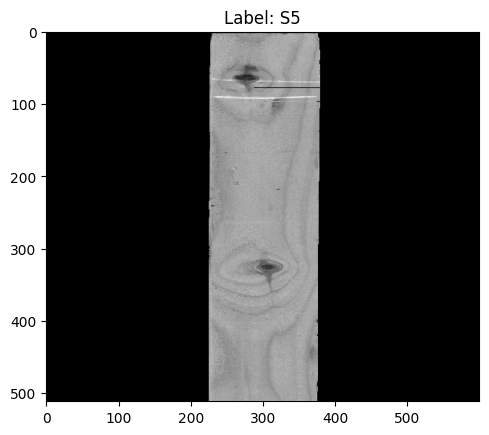

Press Enter to continue


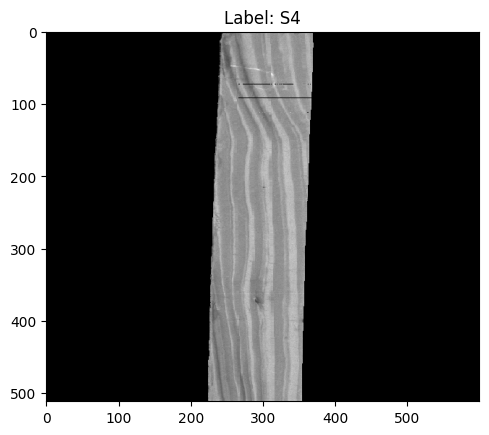

Press Enter to continue


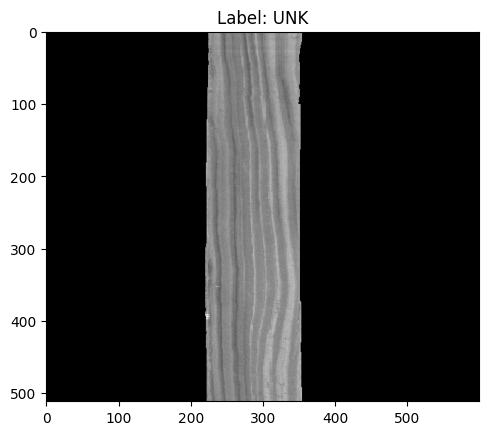

Press Enter to continue


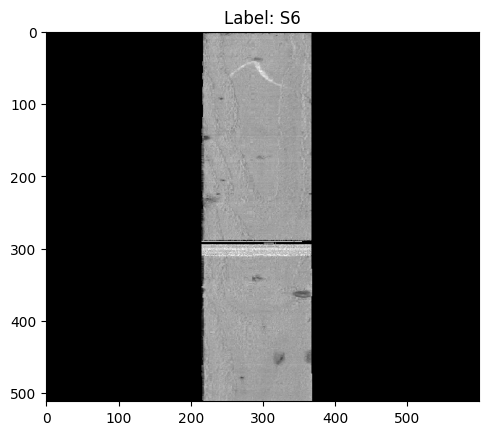

Press Enter to continue


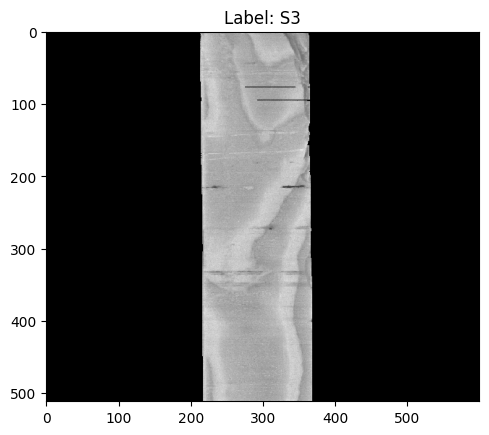

Press Enter to continue


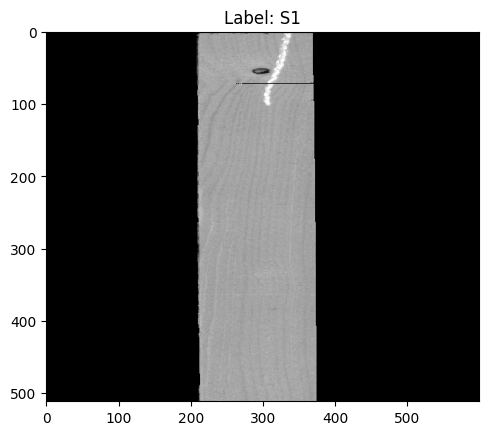

Press Enter to continue


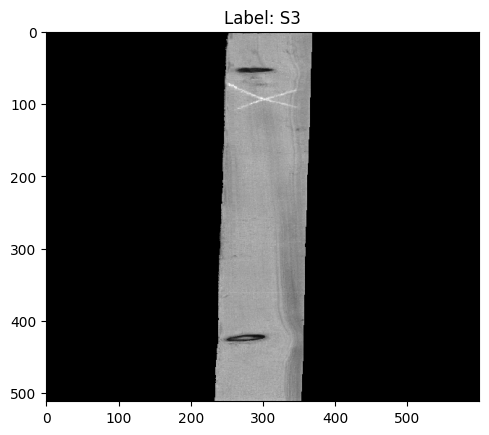

Press Enter to continue


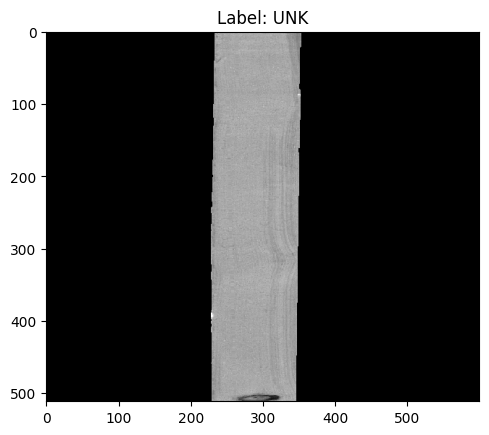

Press Enter to continue


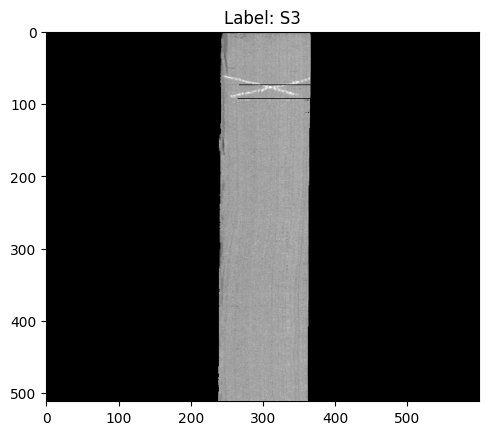

Press Enter to continue


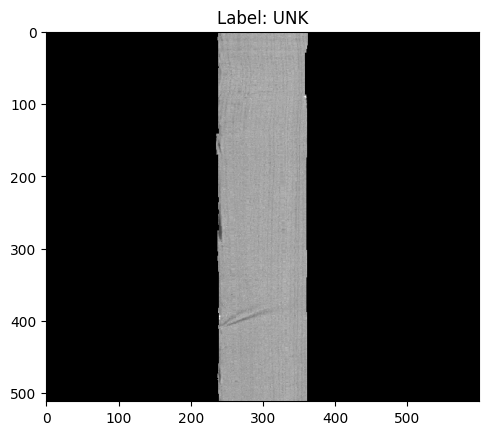

Press Enter to continue


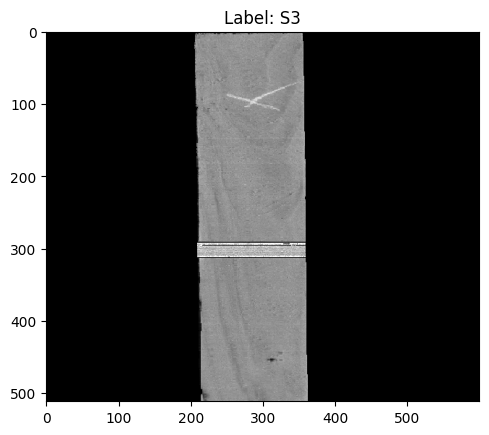

Press Enter to continue


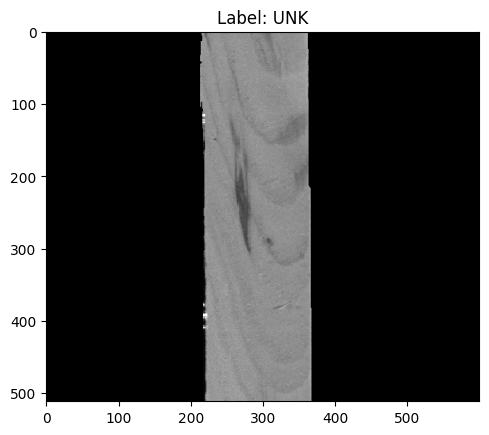

Press Enter to continue


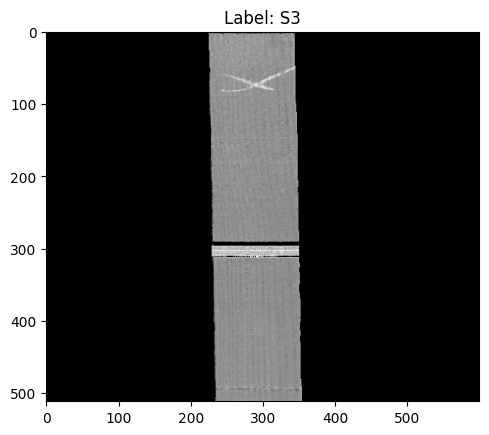

Press Enter to continue


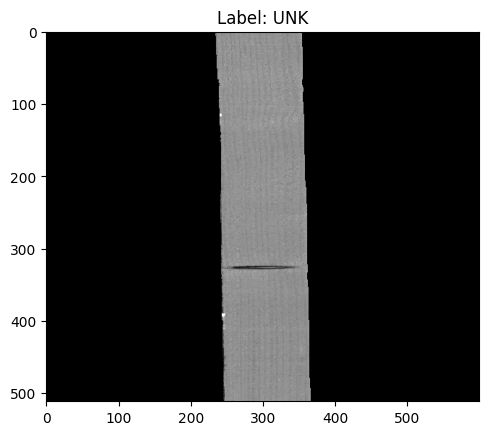

Press Enter to continue


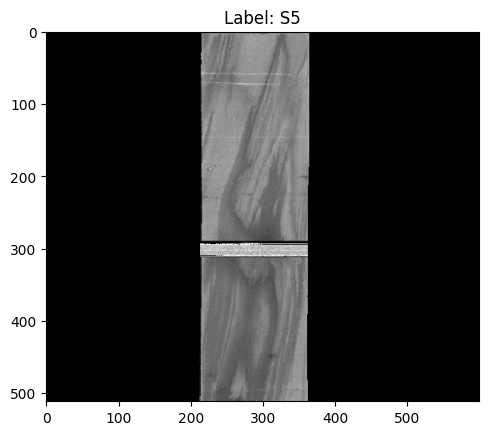

Press Enter to continue


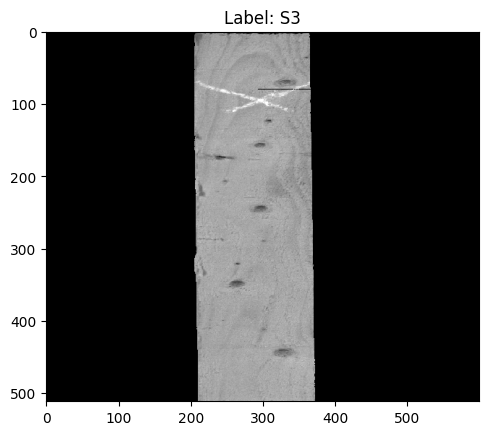

Press Enter to continue


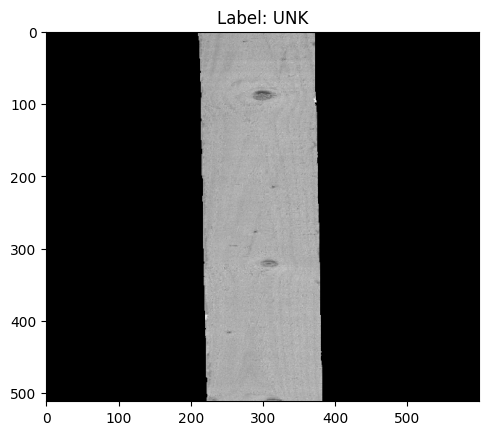

Press Enter to continue


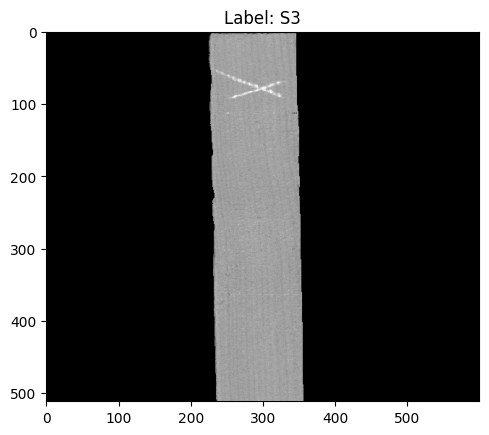

Press Enter to continue


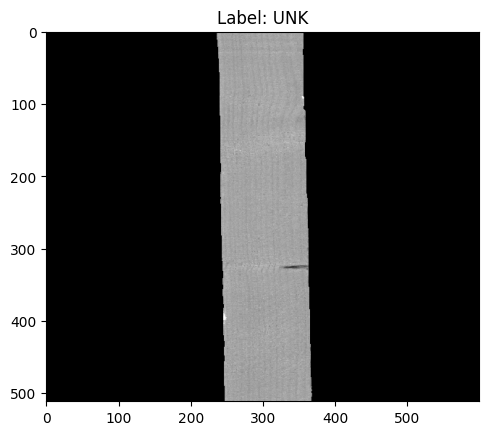

Press Enter to continue


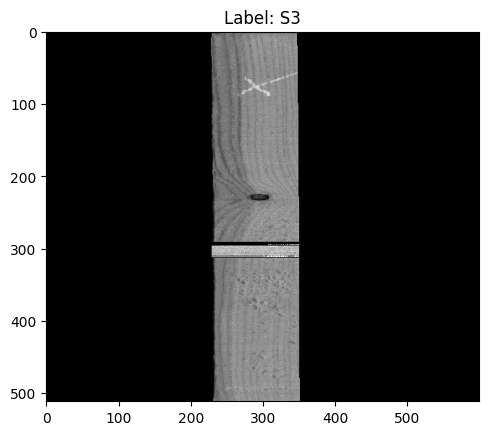

Press Enter to continue


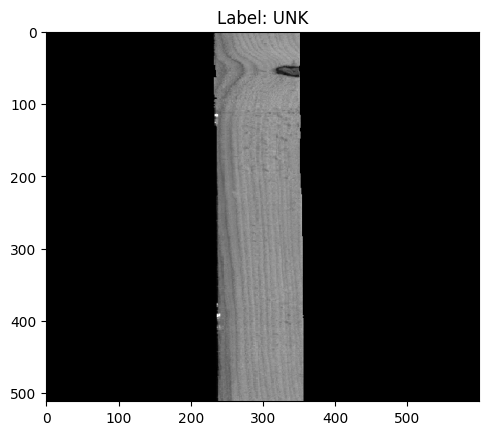

Press Enter to continue


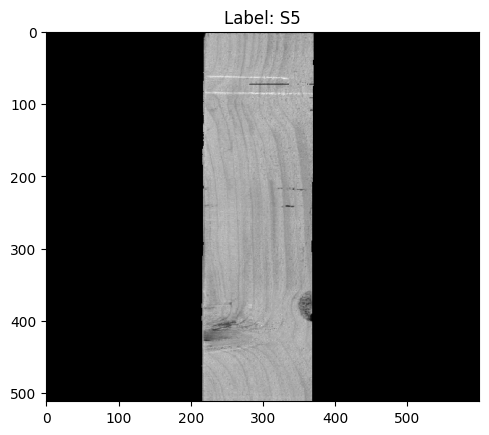

Press Enter to continue


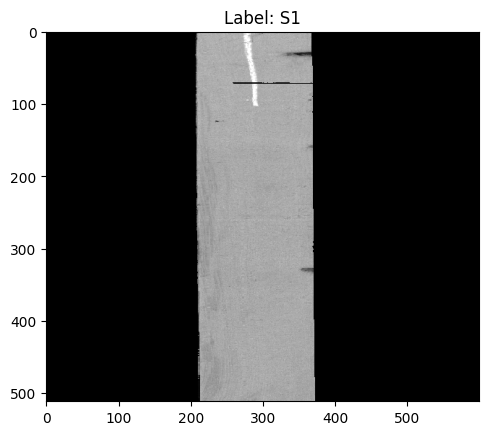

KeyboardInterrupt: Interrupted by user

In [15]:
# path to the file containing predictions on the test set
predictions_file = os.path.join(os.getcwd(), "test_set_predictions.csv")

# use the function to show images and labels
show_image_with_label(predictions_file)